In [1]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

In [2]:
# Do not modify
df = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv",
    sep=",",
)
df.head()

df = df.drop(["cbwd"], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how="any")  # drop samples who has nan feature
df.head()

idx = np.logical_or(
    np.logical_and(df["year"].values == 2014, df["month"].values < 3),
    np.logical_and(df["year"].values == 2013, df["month"].values == 12),
)
X = df.loc[idx].drop("pm2.5", axis=1)
y = df.loc[idx]["pm2.5"].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_sc = StandardScaler()
X_train_std = X_sc.fit_transform(X_train)
X_test_std = X_sc.transform(X_test)
y_sc = StandardScaler()
y_train_std = y_sc.fit_transform(y_train[:, None]).ravel()
y_test_std = y_sc.transform(y_test[:, None]).ravel()

In [4]:
class PolynomialRegressionGD(object):
    def __init__(self, degree=2, eta=0.001, n_iter=20, random_state=1):
        self.degree = degree
        self.sc = StandardScaler()
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        X_poly = self.get_poly(X)
        X_poly = self.sc.fit_transform(X_poly)

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X_poly.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X_poly)

            # Cost function
            error = y - output
            cost = (error**2).sum() / 2.0
            self.cost_.append(cost)

            # Update rule
            self.w_[1:] += self.eta * X_poly.T.dot(error)
            self.w_[0] += self.eta * error.sum()

        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        X_poly = self.get_poly(X)
        X_poly = self.sc.transform(X_poly)
        return self.net_input(X_poly)

    def get_poly(self, X):
        X_poly = X.copy()
        for d in range(2, self.degree + 1):
            X_poly = np.concatenate((X_poly, X**d), axis=1)
        return X_poly

In [5]:
def plot_residual_plot(y_train, y_train_pred, y_test, y_test_pred):
    # plt.figure(figsize=(8, 8))
    plt.figure()

    plt.scatter(
        y_train_pred,
        y_train_pred - y_train,
        c="steelblue",
        edgecolor="white",
        marker="o",
        # s=35,
        # alpha=0.9,
        label="Training data",
    )
    plt.scatter(
        y_test_pred,
        y_test_pred - y_test,
        c="limegreen",
        edgecolor="white",
        marker="s",
        # s=35,
        # alpha=0.9,
        label="Test data",
    )

    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc="upper left")
    plt.hlines(
        y=0,
        xmin=min([y_train_pred.min(), y_test_pred.min()]),
        xmax=max([y_train_pred.max(), y_test_pred.max()]),
        color="red",
        lw=2,
    )
    plt.tight_layout()

Quadratic R2 train: 0.59, test: 0.59


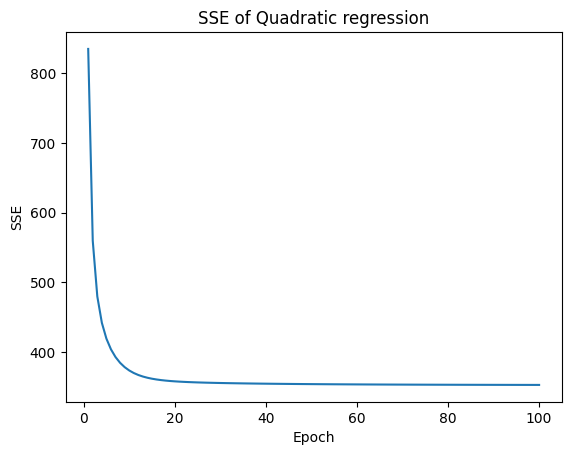

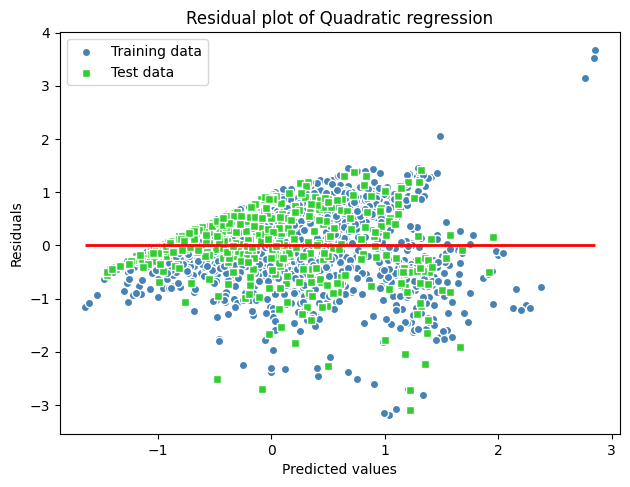

Cubic R2 train: 0.60, test: 0.59


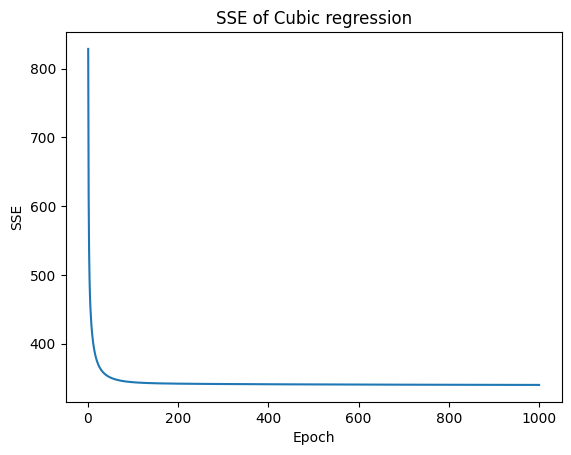

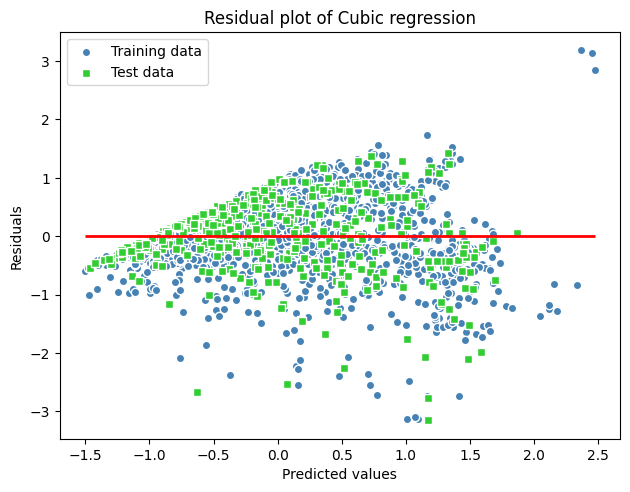

In [6]:
def polynomial(clf, name):
    clf.fit(X_train_std, y_train_std)
    y_train_pred = clf.predict(X_train_std)
    y_test_pred = clf.predict(X_test_std)

    # Training and test MSE
    print(
        "%s R2 train: %.2f, test: %.2f"
        % (
            name,
            r2_score(y_train_std, y_train_pred),
            r2_score(y_test_std, y_test_pred),
        )
    )
    # Plot loss over iteration
    plt.figure()
    plt.plot(range(1, clf.n_iter + 1), clf.cost_)
    plt.ylabel("SSE")
    plt.xlabel("Epoch")
    plt.title("SSE of %s regression" % name)
    plt.show()

    plot_residual_plot(y_train_std, y_train_pred, y_test_std, y_test_pred)
    plt.title("Residual plot of %s regression" % name)
    plt.show()


quad_regr = PolynomialRegressionGD(degree=2, eta=0.0002, n_iter=100)
cubic_regr = PolynomialRegressionGD(degree=3, eta=0.0001, n_iter=1000)

polynomial(quad_regr, "Quadratic")
polynomial(cubic_regr, "Cubic")

Random Forest R2 train: 0.99, test: 0.93


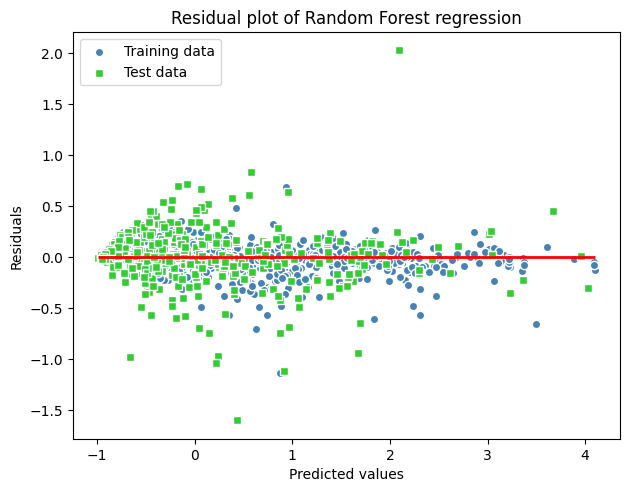

In [7]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators=200, criterion="squared_error", random_state=1, n_jobs=-1
)
forest.fit(X_train_std, y_train_std)
forest_train_pred = forest.predict(X_train_std)
forest_test_pred = forest.predict(X_test_std)

print(
    "Random Forest R2 train: %.2f, test: %.2f"
    % (
        r2_score(y_train_std, forest_train_pred),
        r2_score(y_test_std, forest_test_pred),
    )
)

plot_residual_plot(
    y_train_std, forest_train_pred, y_test_std, forest_test_pred
)
plt.title("Residual plot of Random Forest regression")
plt.show()